In [1]:
indir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/enriched_barcodes/clonal_shifts/variants_init/donors/donor1/clones/knn_kparam_3"
outdir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/enriched_barcodes/single_clones/donor1/cloneMethod_variants_init_knn_resolution_3/clonalShift_method_clones/clones_ranked"
cells_meta_f = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/enriched_barcodes/single_clones/donor1/cloneMethod_variants_init_knn_resolution_3/clonalShift_method_clones/cells_meta.tsv"
is_mt = False
condition = None

# Input info
# indir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clonal_shifts/variants_init/donors/donor1/mt_as_clones/af.0.1_othaf.0.1_cov.10_othcov.10_ncells.10_othncells.0.25_mean.0/"
# outdir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/single_clones/donor1/cloneMethod_variants_init_mt_bestparams_af.0.1_othaf.0.1_cov.10_othcov.10_ncells.10_othncells.0.25_mean.0/clonalShift_method_mt_as_clones/clones_ranked/"
# is_mt = True
# #only used if clone is mt, to remove some clones. see where we save the csv and text file
# cells_meta_f = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/single_clones/donor1/cloneMethod_variants_init_mt_bestparams_af.0.1_othaf.0.1_cov.10_othcov.10_ncells.10_othncells.0.25_mean.0/clonalShift_method_mt_as_clones/cells_meta.tsv"
# condition=None

clone_id = "cloneID" # "den_clust"
p_thresh = 0.1 
#clust_id = "clusterID"

In [2]:
%load_ext autoreload
%autoreload 2


In [3]:
%load_ext autoreload
%autoreload 2
from glob import glob
import pandas as pd
import numpy as np
from os.path import join, exists
import os
from tqdm.notebook import tqdm

from scipy.stats import hypergeom, fisher_exact
from statsmodels.stats import multitest 

import seaborn as sns
import matplotlib.pyplot as plt

from src import clonal_shifts as cs
from icecream import ic

from mplh import cluster_help as ch

from scipy.stats import rankdata, gmean


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
fig_utils from mplh


In [4]:
indir

'/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/enriched_barcodes/clonal_shifts/variants_init/donors/donor1/clones/knn_kparam_3'

## Load ncells and save to output. Sort by ncells

In [5]:
noInput_ncells = pd.read_csv(join(indir, "noInput_ncells.csv"),  index_col=0)
input_ncells = pd.read_csv(join(indir, "input_ncells.csv"), index_col=0)

# input_ncells_df = input_ncells.reset_index().melt(id_vars="index", value_name="pval")
# noInput_ncells_df = noInput_ncells.reset_index().melt(id_vars="index", value_name="pval")

# noInput_ncells_df["condition"] = "cultured"
# noInput_shuffle_df["condition"] = "cultured"
# input_ncells_df["condition"] = "input"
# input_shuffle_df["condition"] = "input"

input_ncells = input_ncells.groupby(clone_id).sum()[["count"]].sort_values(by="count")[::-1]
noInput_ncells = noInput_ncells.groupby(clone_id).sum()[["count"]].sort_values(by="count")[::-1]
ncells_df = pd.merge(input_ncells,noInput_ncells,left_index=True, right_index=True, suffixes=["_input", "_cultured"])
ncells_df = ncells_df.loc[ncells_df.sum(axis=1).sort_values()[::-1].index]
ncells_df

,count_input,count_cultured
cloneID,,
1_7,218,102
1_15,67,129
1_14,43,152
1_16,54,128
1_19,114,61
1_18,35,138
1_21,55,100
1_22,37,104
1_23,11,124


## Load shuffle hypergeometric results for input and cultured
## Convert into long df with cloneID ('index'), clusterID ('variable'), pval, method (hypergeo or one of four shuffle methods), and condition ('input' or 'cultured')

In [6]:
noInput_hyper = pd.read_csv(join(indir, "noInput_hypergeo_pvals.csv"),  index_col=0)
noInput_shuffle_df = pd.read_csv(join(indir, "noInput_shuffle_results_pvals.csv"), index_col=0)
noInput_shuffle_df = noInput_shuffle_df.rename({"value":"pval"}, axis=1)

input_hyper = pd.read_csv(join(indir, "input_hypergeo_pvals.csv"), index_col=0)
input_shuffle_df = pd.read_csv(join(indir, "input_shuffle_results_pvals.csv"), index_col=0)

input_shuffle_df = input_shuffle_df.rename({"value":"pval"}, axis=1)
input_shuffle_df

input_hyper_df = input_hyper.reset_index().melt(id_vars="index", value_name="pval")
input_hyper_df["method"] = "hypergeo"
noInput_hyper_df = noInput_hyper.reset_index().melt(id_vars="index", value_name="pval")
noInput_hyper_df["method"] = "hypergeo"



noInput_hyper_df["condition"] = "cultured"
noInput_shuffle_df["condition"] = "cultured"
input_hyper_df["condition"] = "input"
input_shuffle_df["condition"] = "input"


In [7]:
input_df = pd.concat((input_hyper_df, input_shuffle_df), axis=0, ignore_index=True)
input_df

noInput_df = pd.concat((noInput_hyper_df, noInput_shuffle_df), axis=0, ignore_index=True)
noInput_df

df = pd.concat((input_df, noInput_df), axis=0).reset_index(drop=True)
#df = pd.merge(input_df, noInput_df, on=["index", "variable", "method"], suffixes=["_input", "_cultured"])
df

,index,variable,pval,method,condition
0,1_14,CLP,0.265103,hypergeo,input
1,1_15,CLP,0.551699,hypergeo,input
2,1_16,CLP,0.731114,hypergeo,input
3,1_18,CLP,0.393321,hypergeo,input
4,1_19,CLP,0.393321,hypergeo,input
...,...,...,...,...,...
1983,1_30,neutrophil B,1.000000,clone_min,cultured
1984,1_31,neutrophil B,1.000000,clone_min,cultured
1985,1_35,neutrophil B,1.000000,clone_min,cultured
1986,1_37,neutrophil B,1.000000,clone_min,cultured


## Create 'sig score' that merges the hypergeo and the shuffle results. Score 0-4, with 4 the highest

In [8]:
p_df = df.copy()
p_df["is_sig"] = p_df["pval"]<p_thresh
p_df

def check_sig(x):
    #print(x.head())
    name, clust, cond = x.name
    x = x.set_index("method")["is_sig"]
    assert(x.index.duplicated().sum()==0)
    print('x', x)
    #print('x',x )
#     sig = x["hypergeo"] 
#     #print('sig', sig)
#     sig = sig.astype(int) + (x["global_all"]).astype(int)
#     sig = sig.astype(int) + (x["clone_min"]).astype(int)
#     sig = sig.astype(int) + (x["global_min"]).astype(int)
    

    
#     sig[(x["hypergeo"]==True)] = 1
#     sig[(x["hypergeo"]==True) & (x["global_all"]==True) ] = 2
#     sig[(x["hypergeo"]==True) & (x["global_all"]==True)
#                       & (x["clone_min"]==True)] = 3
    #print('x',x)
    sig = 0    
    if 'hypergeo' not in x.index:
        return sig
    if x["hypergeo"]==True:
        if ("global_all" in x) and x["global_all"]==True:
            if ("clone_min" in x) and (x["clone_min"]==True):
                if ("global_min" in x) and (x["global_min"]==True):
                    sig = 4    
                else:
                    sig = 3
            else:
                sig = 2
        else:
            sig = 1
    return sig

p_df = p_df.groupby(["index","variable", "condition"]).apply(check_sig)
p_df


# df.loc[(df["method"] == "hypergeo") & (df["condition"] == "input")].pivot(index="index", columns="variable", values="pval")

# df.loc[(df["method"] == "hypergeo") & (df["condition"] == "cultured")].pivot(index="index", columns="variable", values="pval")

p_df_out = p_df.reset_index().rename({0:"significant_score"}, axis=1)
#p_df_out.set_index( )
p_df_out["cluster_condition"] = p_df_out.apply(lambda x: f'{x["variable"]}_{x["condition"]}', axis=1)


#p_df_out["clone_condition"] = p_df_out.apply(lambda x: f'{x["index"]}_{x["condition"]}', axis=1)

p_df_out = p_df_out.pivot(index='index', columns='cluster_condition', values="significant_score").fillna(0)

p_df_out

x method
hypergeo      False
global_all    False
global_min    False
clone_all     False
clone_min     False
Name: is_sig, dtype: bool
x method
hypergeo      False
global_all     True
global_min    False
clone_all      True
clone_min     False
Name: is_sig, dtype: bool
x method
hypergeo      False
global_all    False
global_min    False
clone_all     False
clone_min     False
Name: is_sig, dtype: bool
x method
hypergeo      False
global_all    False
global_min    False
clone_all     False
clone_min     False
Name: is_sig, dtype: bool
x method
hypergeo      False
global_all    False
global_min    False
clone_all     False
clone_min     False
Name: is_sig, dtype: bool
x method
hypergeo      False
global_all    False
global_min    False
clone_all     False
clone_min     False
Name: is_sig, dtype: bool
x method
hypergeo      False
global_all    False
global_min    False
clone_all     False
clone_min     False
Name: is_sig, dtype: bool
x method
hypergeo      False
global_all    False
global

x method
hypergeo      False
global_all    False
global_min    False
clone_all     False
clone_min     False
Name: is_sig, dtype: bool
x method
hypergeo      False
global_all    False
global_min    False
clone_all     False
clone_min     False
Name: is_sig, dtype: bool
x method
hypergeo      False
global_all    False
global_min    False
clone_all     False
clone_min     False
Name: is_sig, dtype: bool
x method
hypergeo      False
global_all    False
global_min    False
clone_all      True
clone_min     False
Name: is_sig, dtype: bool
x method
hypergeo      False
global_all    False
global_min    False
clone_all     False
clone_min     False
Name: is_sig, dtype: bool
x method
hypergeo      False
global_all    False
global_min    False
clone_all     False
clone_min     False
Name: is_sig, dtype: bool
x method
hypergeo      False
global_all    False
global_min    False
clone_all     False
clone_min     False
Name: is_sig, dtype: bool
x method
hypergeo      False
global_all    False
global

cluster_condition,CLP_cultured,CLP_input,DC_input,MEP_input,MPP/CMP/GMP B_input,MPP/CMP/GMP C_cultured,MPP/CMP/GMP C_input,MPP/CMP/GMP D_cultured,MPP/CMP/GMP D_input,MPP/CMP/GMP_cultured,...,erythroid_input,macrophage_cultured,macrophage_input,meg/erythroid_cultured,meg/erythroid_input,monocyte_cultured,neutrophil B_cultured,neutrophil B_input,neutrophil_cultured,neutrophil_input
index,,,,,,,,,,,,,,,,,,,,,
1_14,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,2
1_15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1_16,4,0,0,0,0,0,0,0,0,0,...,0,0,3,0,0,0,0,0,0,0
1_18,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1_19,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1_21,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1_22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1_23,0,0,2,0,0,0,0,0,3,0,...,0,0,0,0,0,0,0,0,0,0
1_26,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


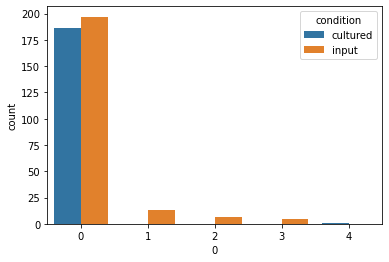

In [9]:
sns.countplot(data=p_df.reset_index(), x=0, hue="condition")
plt.savefig(join(outdir, "hypergeo_sig_score_distribution.pdf"))


## Save heatmap for initial hypergeo 

In [10]:
clone_meta = pd.DataFrame(index=p_df_out.columns, columns = ["condition"])
clone_meta["condition"] = ["input" if "input" in x else "cultured" for x in clone_meta.index]
clone_meta

,condition
cluster_condition,
CLP_cultured,cultured
CLP_input,input
DC_input,input
MEP_input,input
MPP/CMP/GMP B_input,input
MPP/CMP/GMP C_cultured,cultured
MPP/CMP/GMP C_input,input
MPP/CMP/GMP D_cultured,cultured
MPP/CMP/GMP D_input,input


## Input and culture in same heatmap- show clones that were significant in i'th Input cluster label and j'th culture cluster label

merge_df                  CLP MPP/CMP/GMP MPP/CMP/GMP C MPP/CMP/GMP D eosonophil  \
CLP                                                                       
DC                                                                        
MEP                                                                       
MPP/CMP/GMP                                                               
MPP/CMP/GMP B                                                             
MPP/CMP/GMP C                                                             
MPP/CMP/GMP D                                                             
eosonophil                                                                
erythroid                                                                 
macrophage     1_16;                                                      
meg/erythroid                                                             
neutrophil                                                                
neutrophil B    

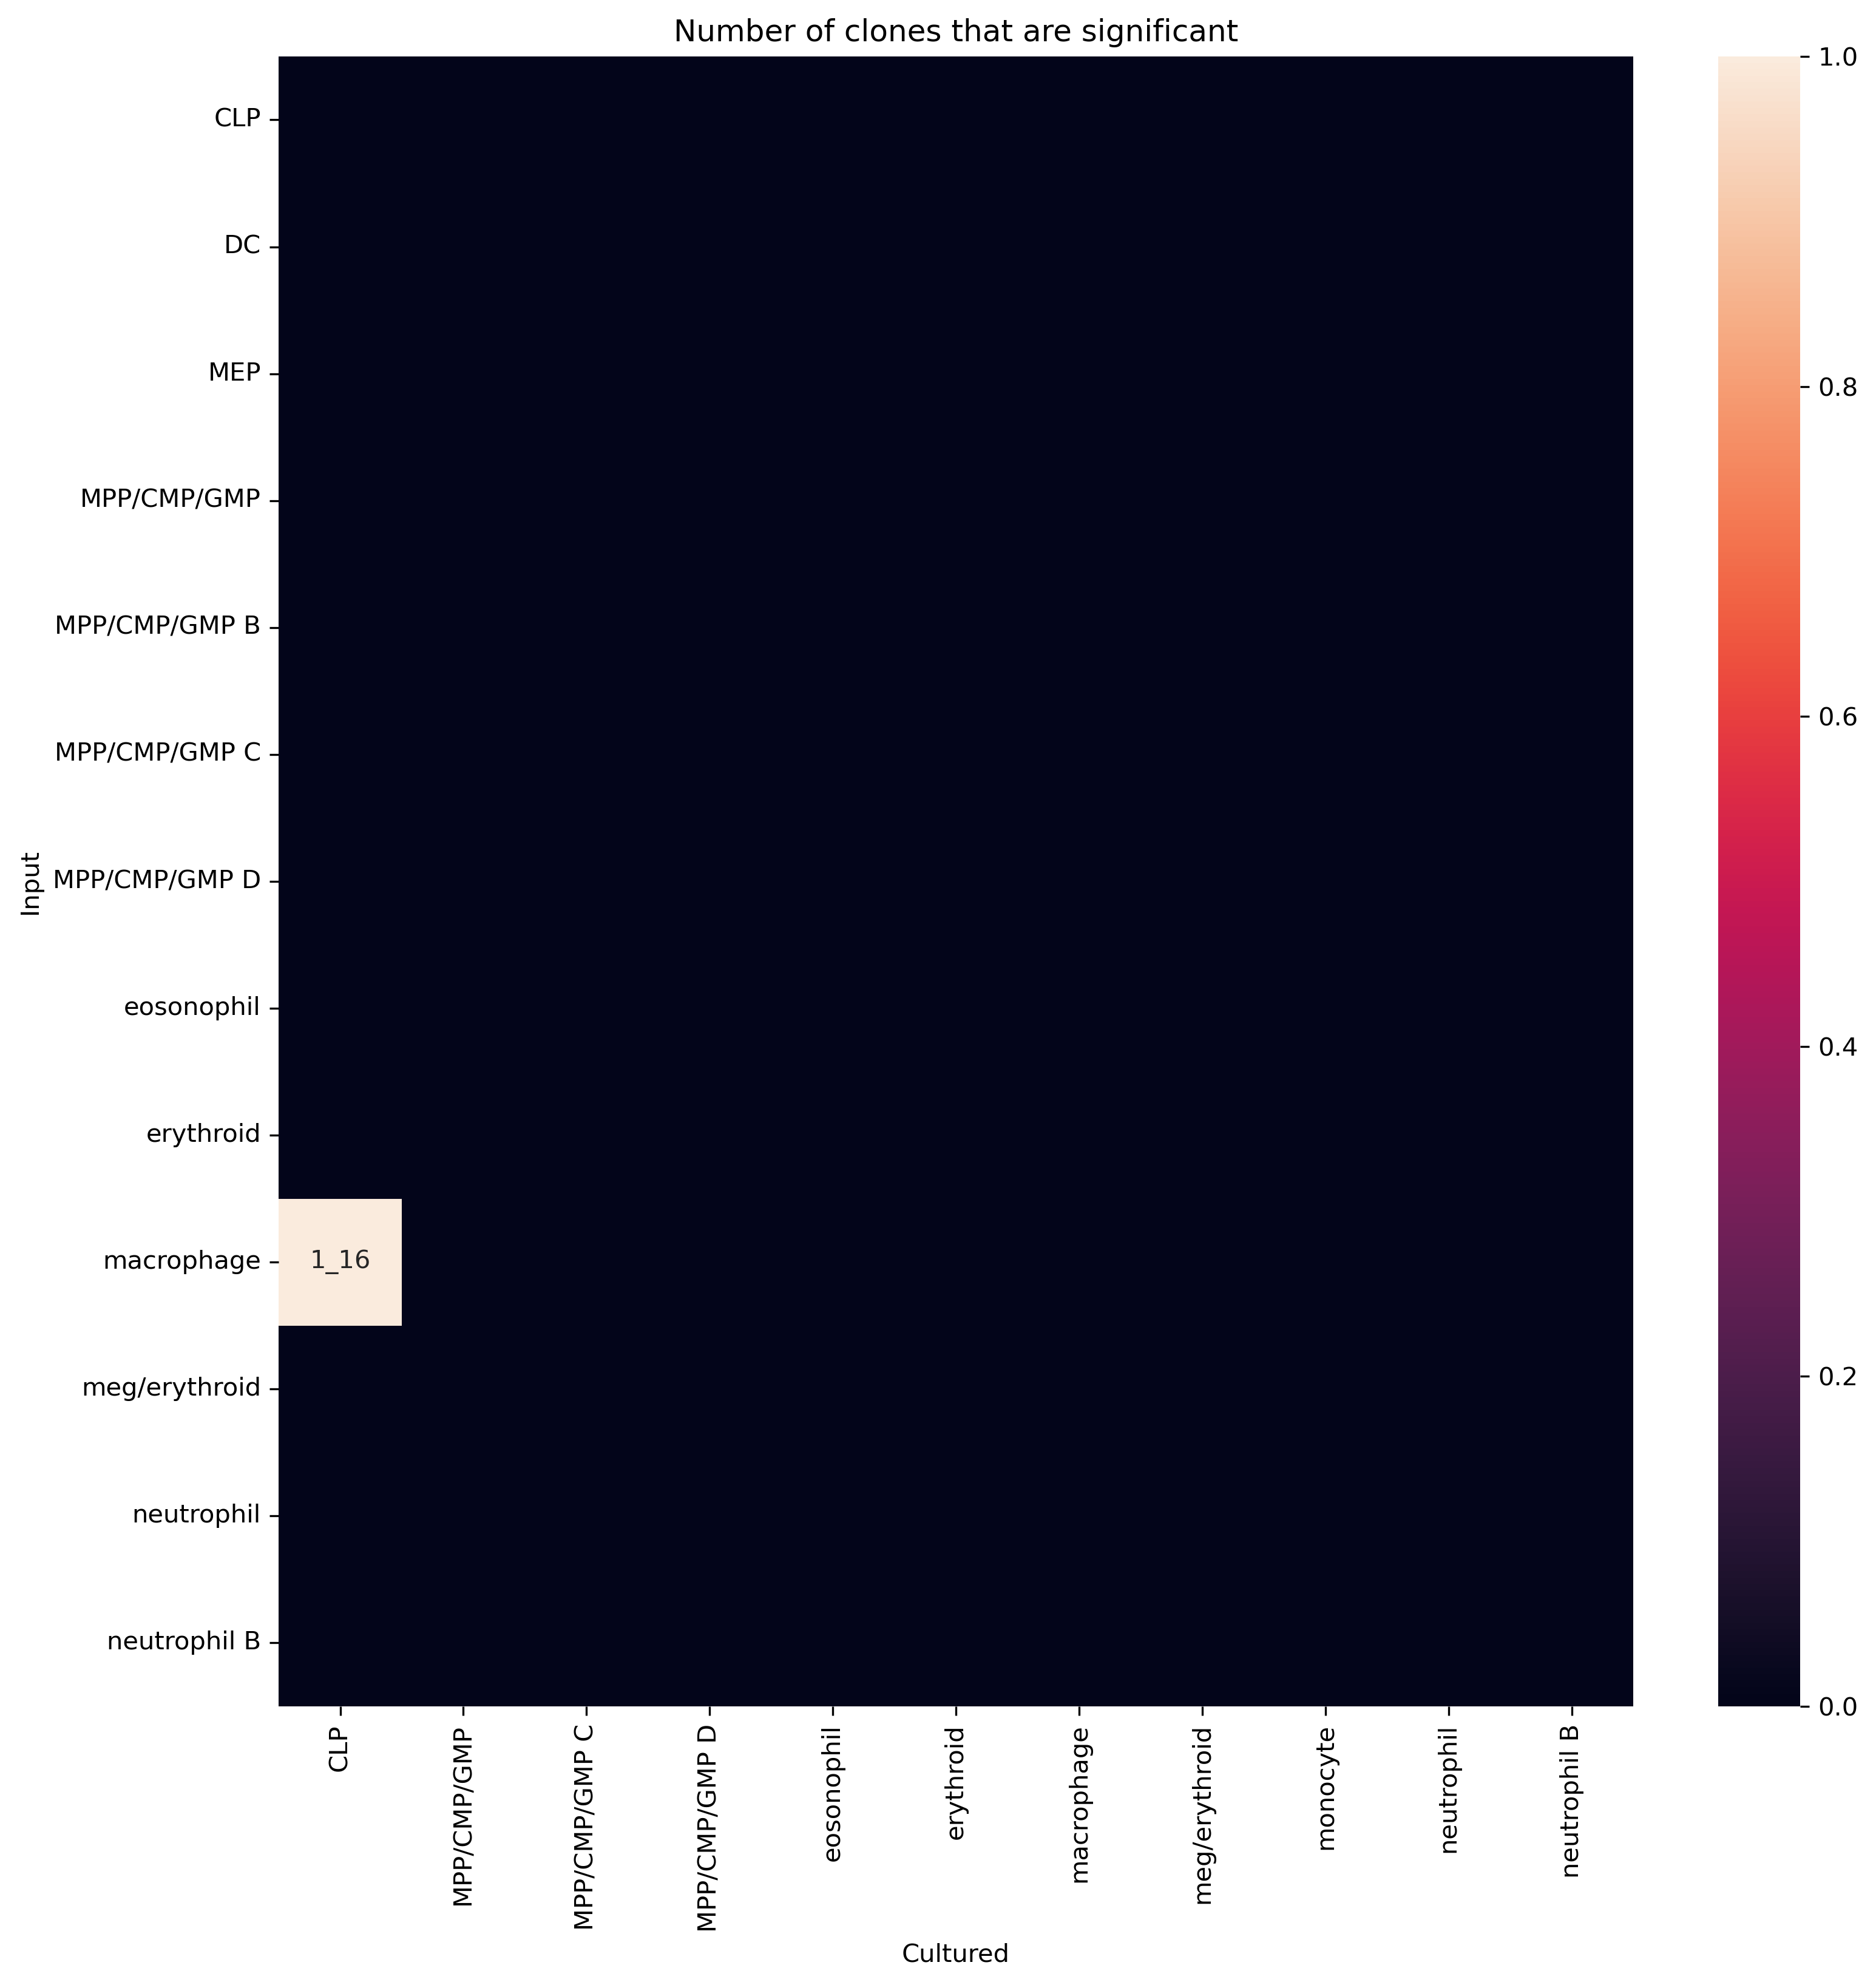

In [11]:
a_input = df.loc[(df["method"] == "hypergeo") & (df["condition"] == "input")].pivot(index="index", columns="variable", values="pval")
b_cultured = df.loc[(df["method"] == "hypergeo") & (df["condition"] == "cultured")].pivot(index="index", columns="variable", values="pval")
merged_df, merged_count_df = cs.merge_hypergeom(a_input, b_cultured, 
                                             "Input", "Cultured", p_thresh=p_thresh,
                                             f_save=join(outdir,f"culture_input_clone_lineages"))


In [12]:
# a_input = df.loc[(df["method"] == "hypergeo") & (df["condition"] == "input")].pivot(index="index", columns="variable", values="pval")
# b_cultured = df.loc[(df["method"] == "hypergeo") & (df["condition"] == "cultured")].pivot(index="index", columns="variable", values="pval")

a_sig = p_df_out[clone_meta[clone_meta["condition"]=="input"].index]
b_sig = p_df_out[clone_meta[clone_meta["condition"]=="cultured"].index]
a_sig.columns = [x.replace("_cultured","").replace("_input","") for x in a_sig.columns]
b_sig.columns = [x.replace("_cultured","").replace("_input","") for x in b_sig.columns]

merge_df               CLP MPP/CMP/GMP C MPP/CMP/GMP D MPP/CMP/GMP eosonophil  \
CLP                                                                    
DC                                                                     
MEP                                                                    
MPP/CMP/GMP B                                                          
MPP/CMP/GMP C                                                          
MPP/CMP/GMP D                                                          
MPP/CMP/GMP                                                            
eosonophil                                                             
erythroid                                                              
macrophage                                                             
meg/erythroid                                                          
neutrophil B                                                           
neutrophil                                             

merge_df                  CLP MPP/CMP/GMP C MPP/CMP/GMP D MPP/CMP/GMP eosonophil  \
CLP                                                                       
DC                                                                        
MEP                                                                       
MPP/CMP/GMP B                                                             
MPP/CMP/GMP C                                                             
MPP/CMP/GMP D                                                             
MPP/CMP/GMP                                                               
eosonophil                                                                
erythroid                                                                 
macrophage     1_16;                                                      
meg/erythroid                                                             
neutrophil B                                                              
neutrophil      

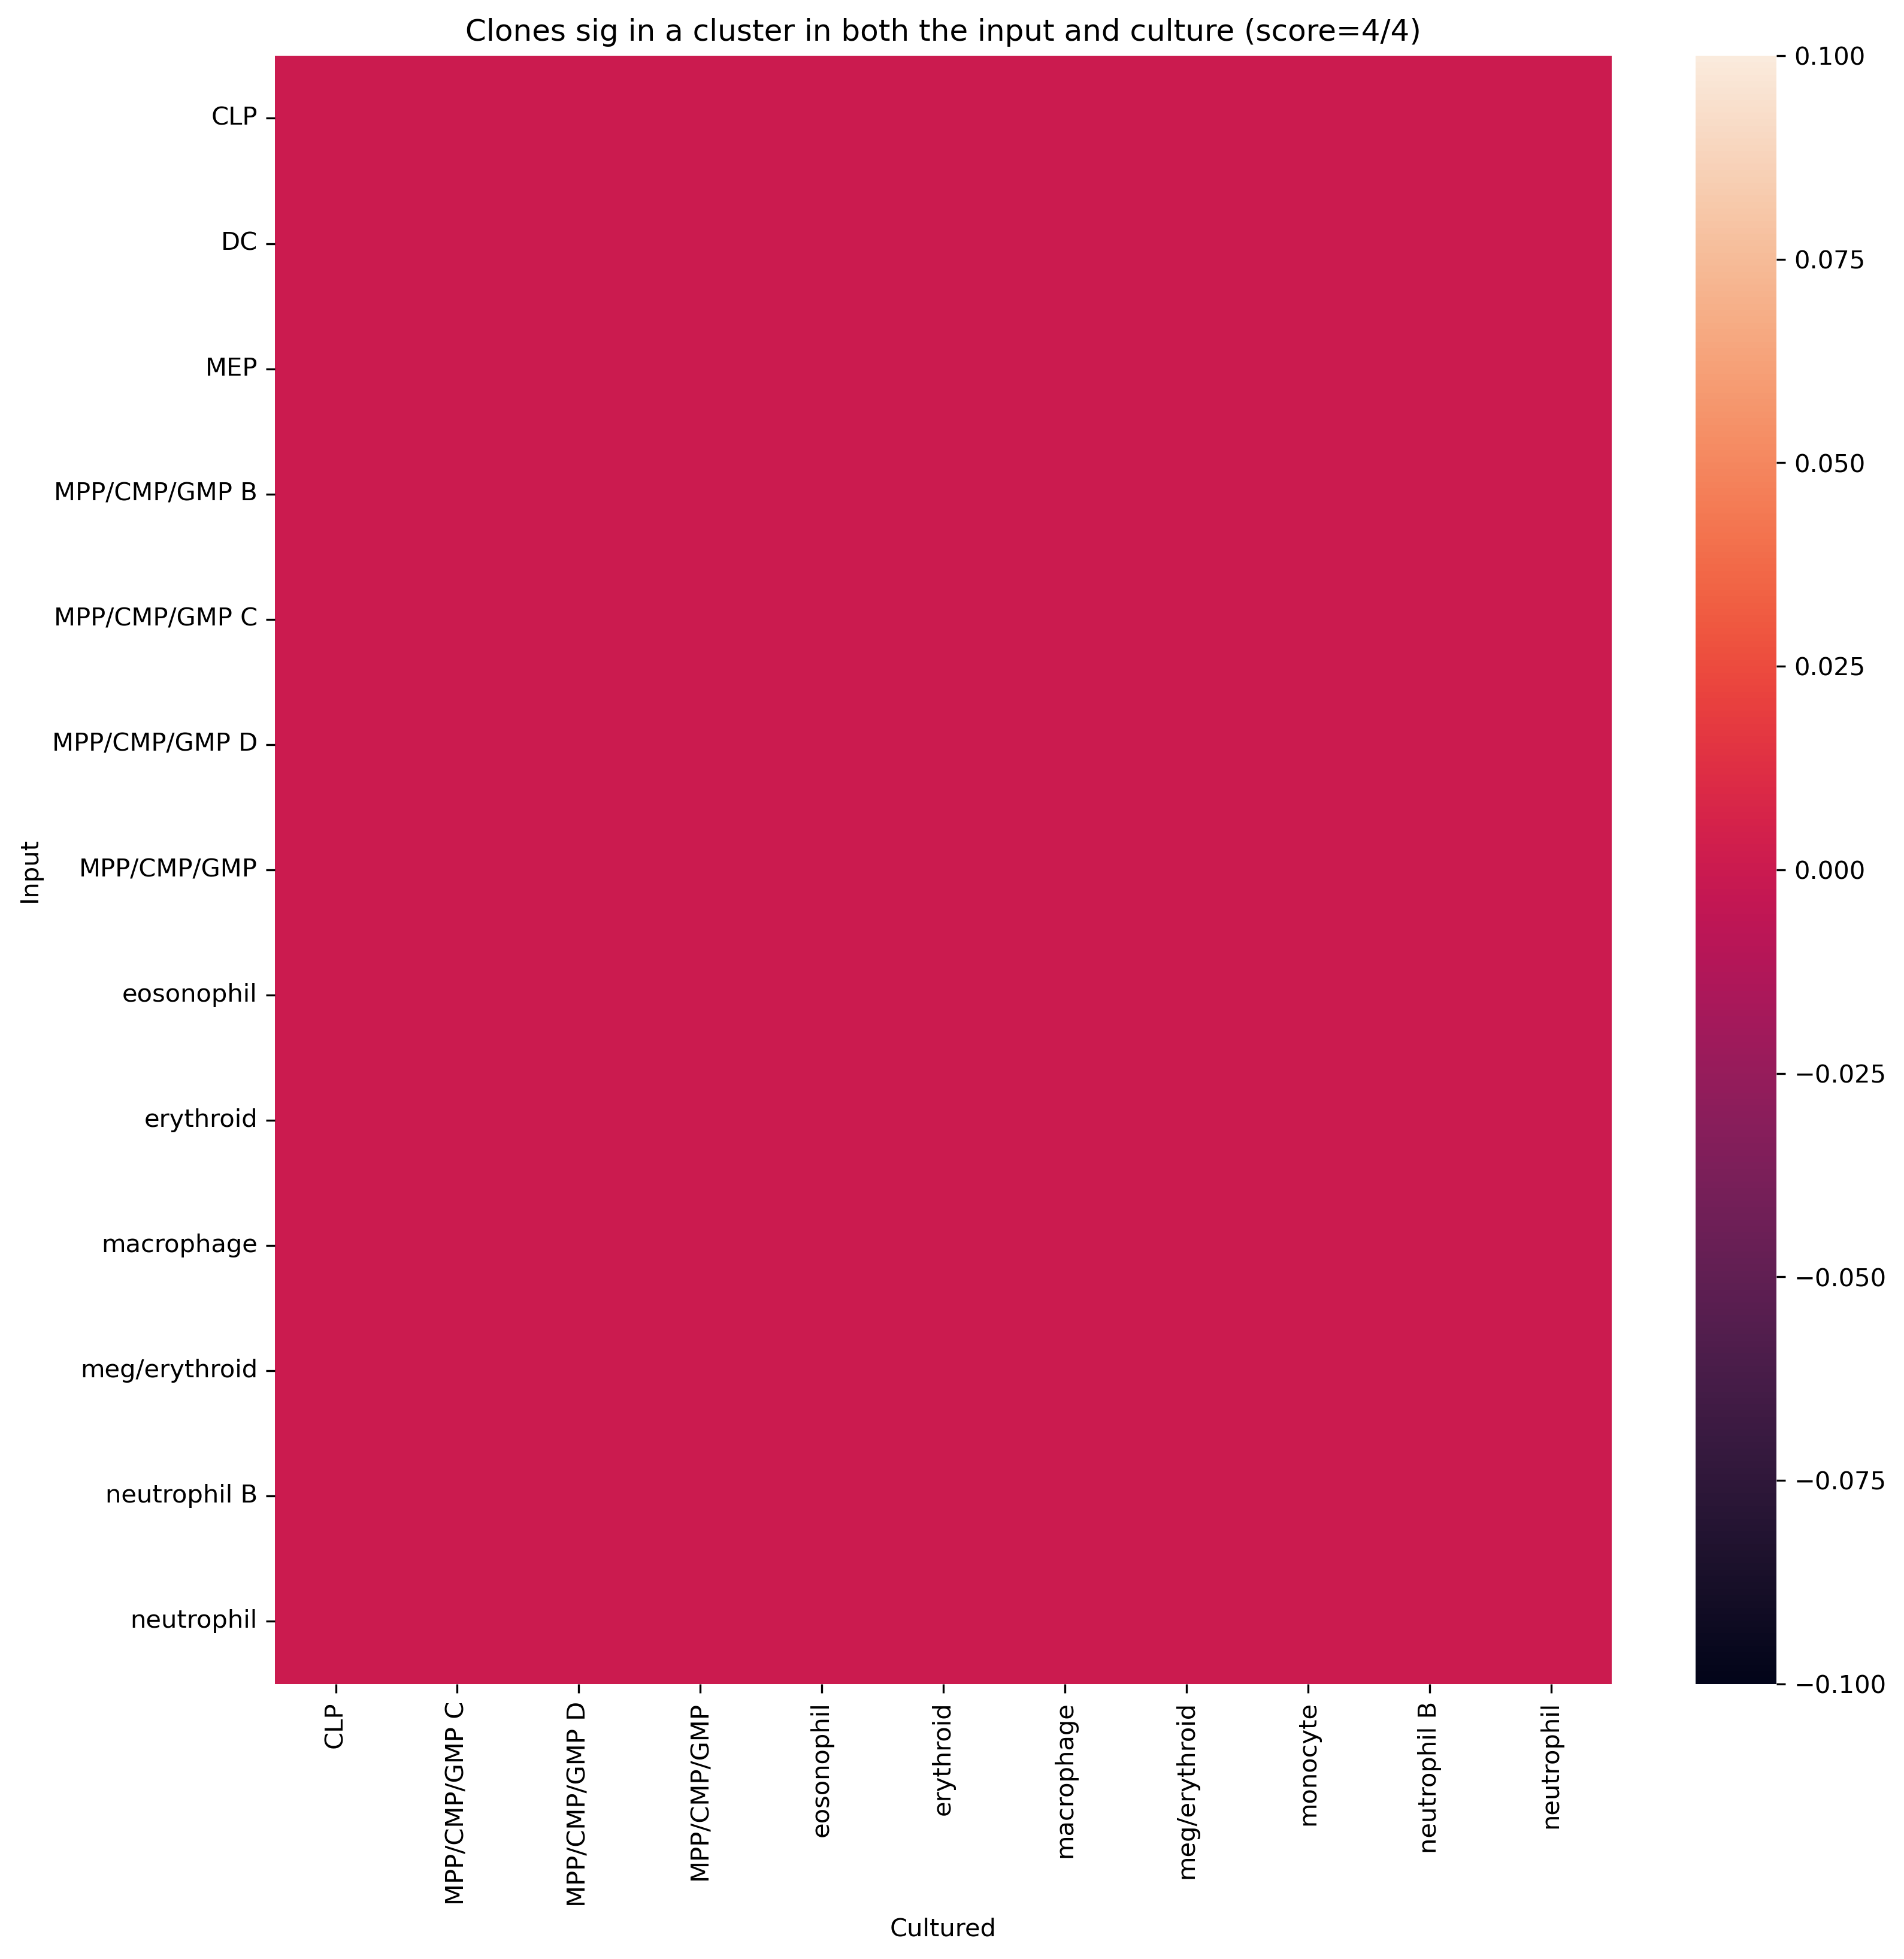

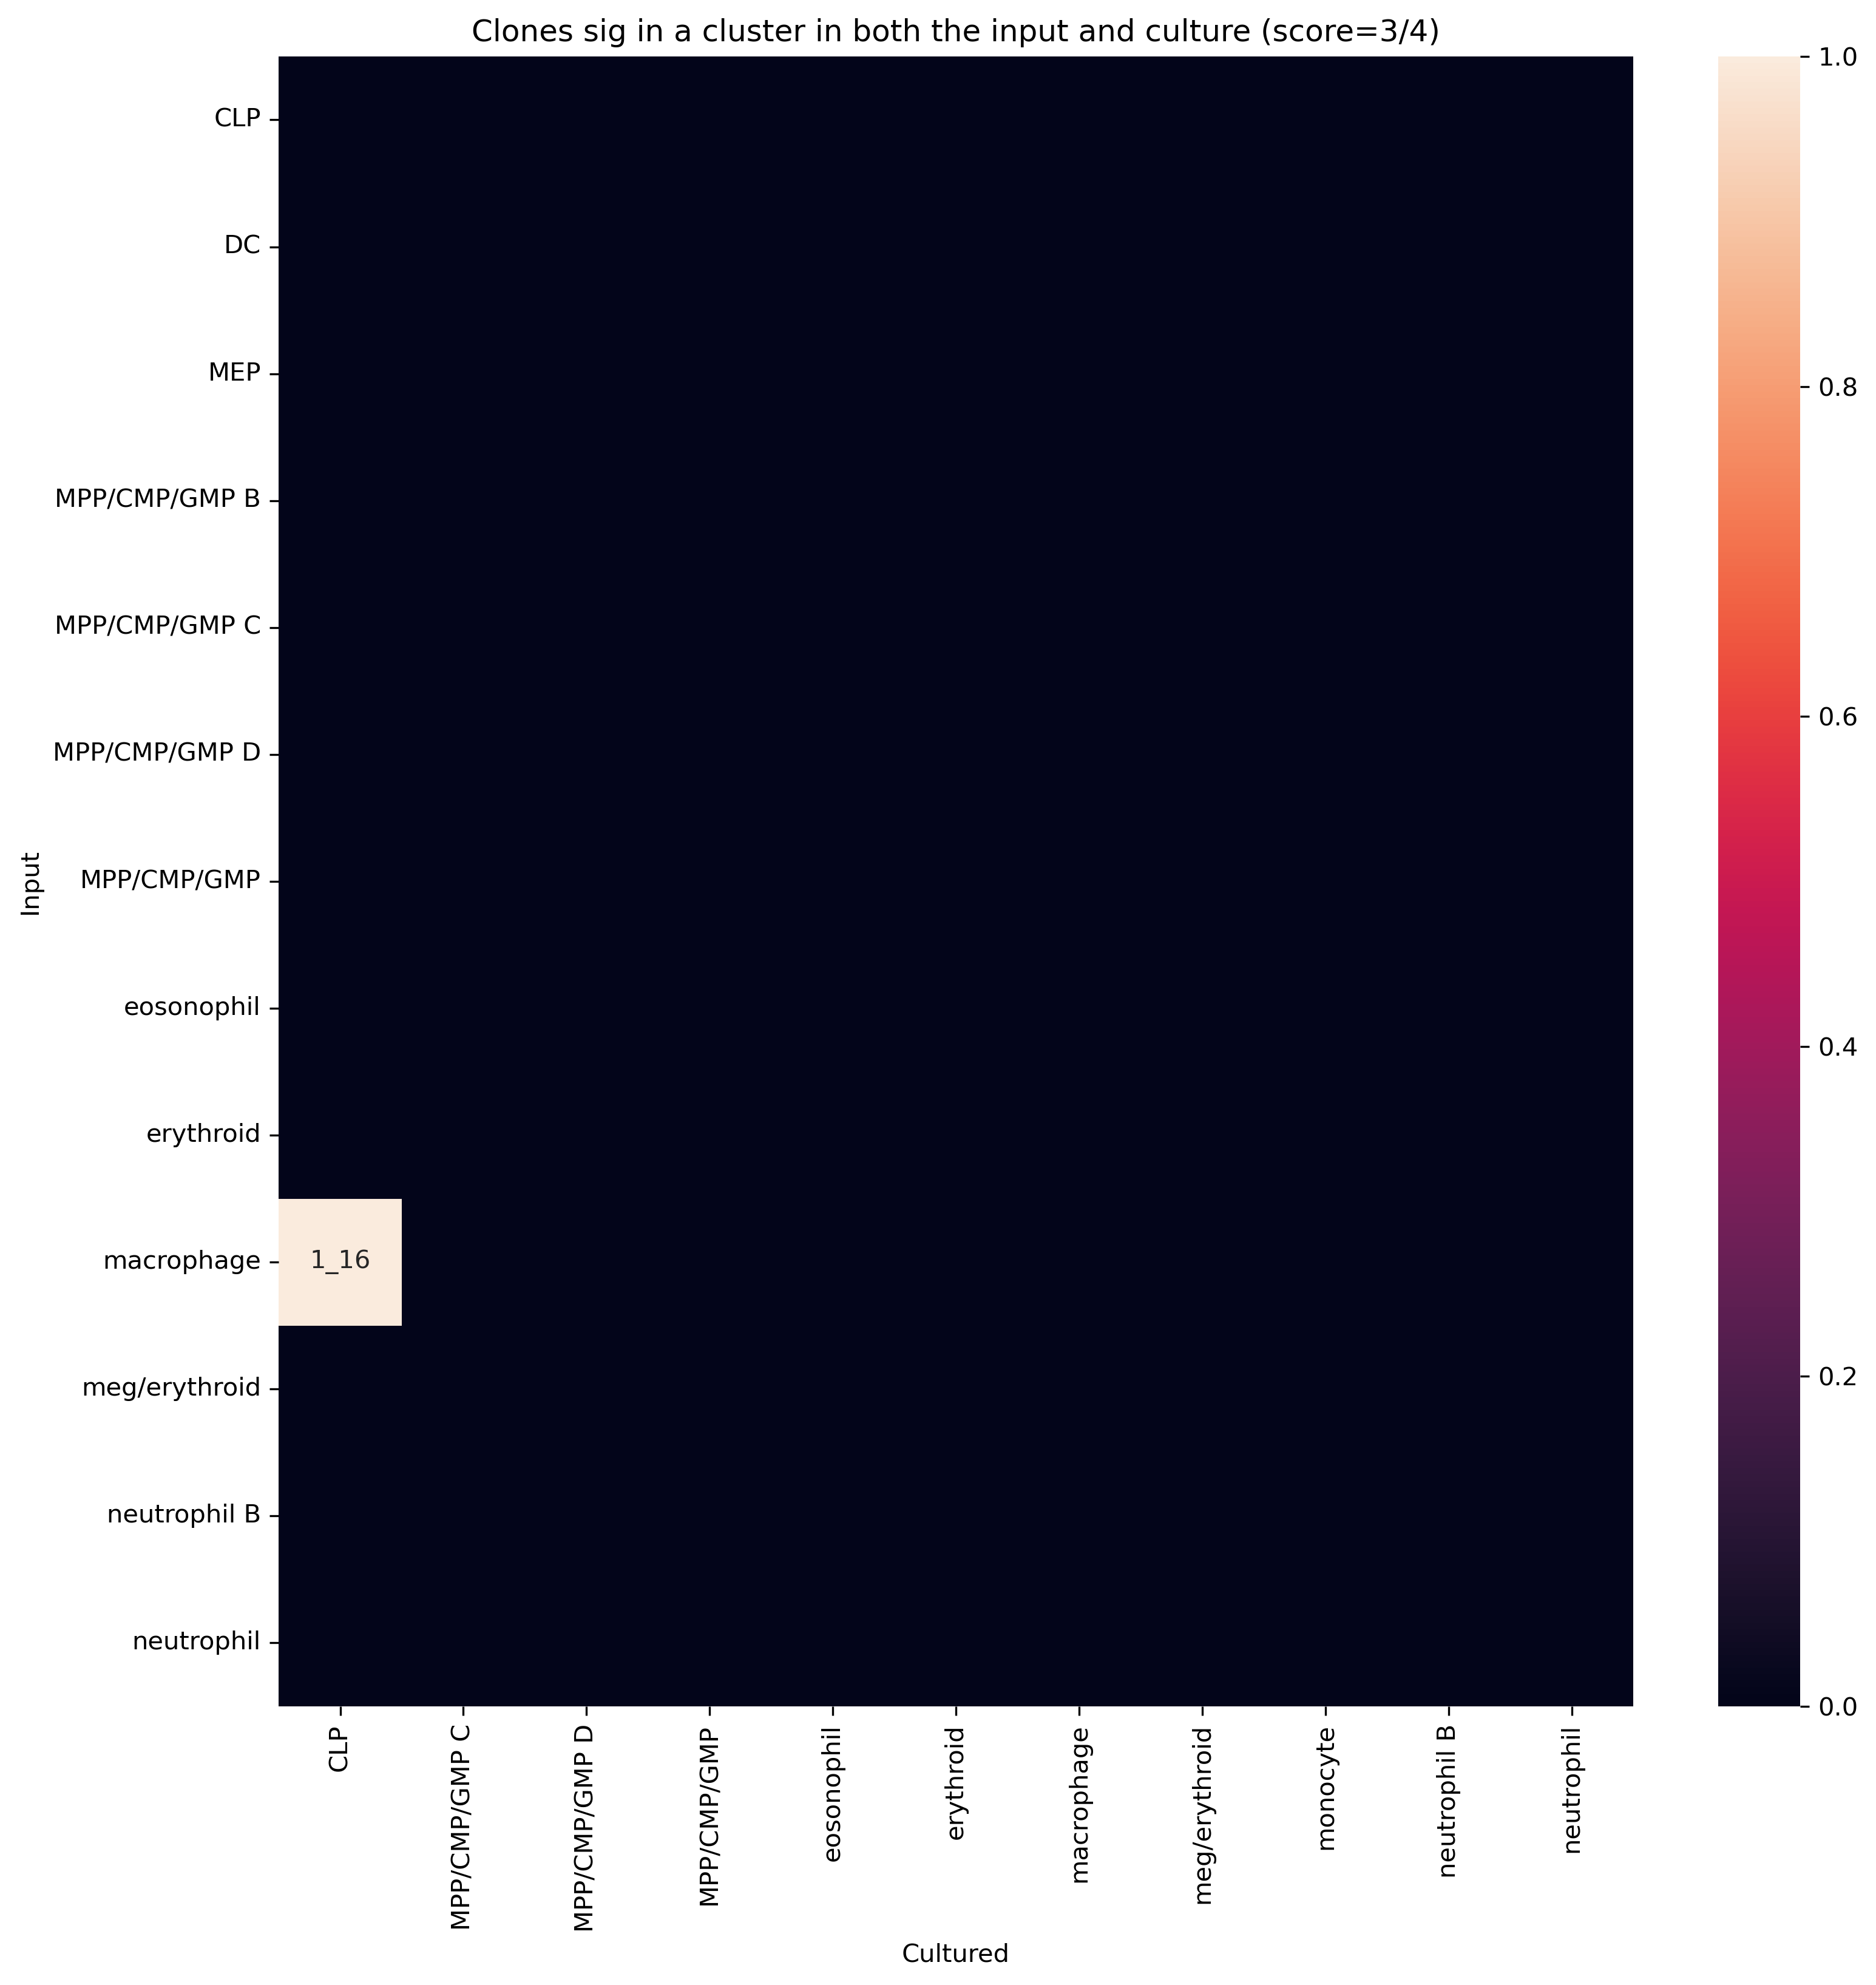

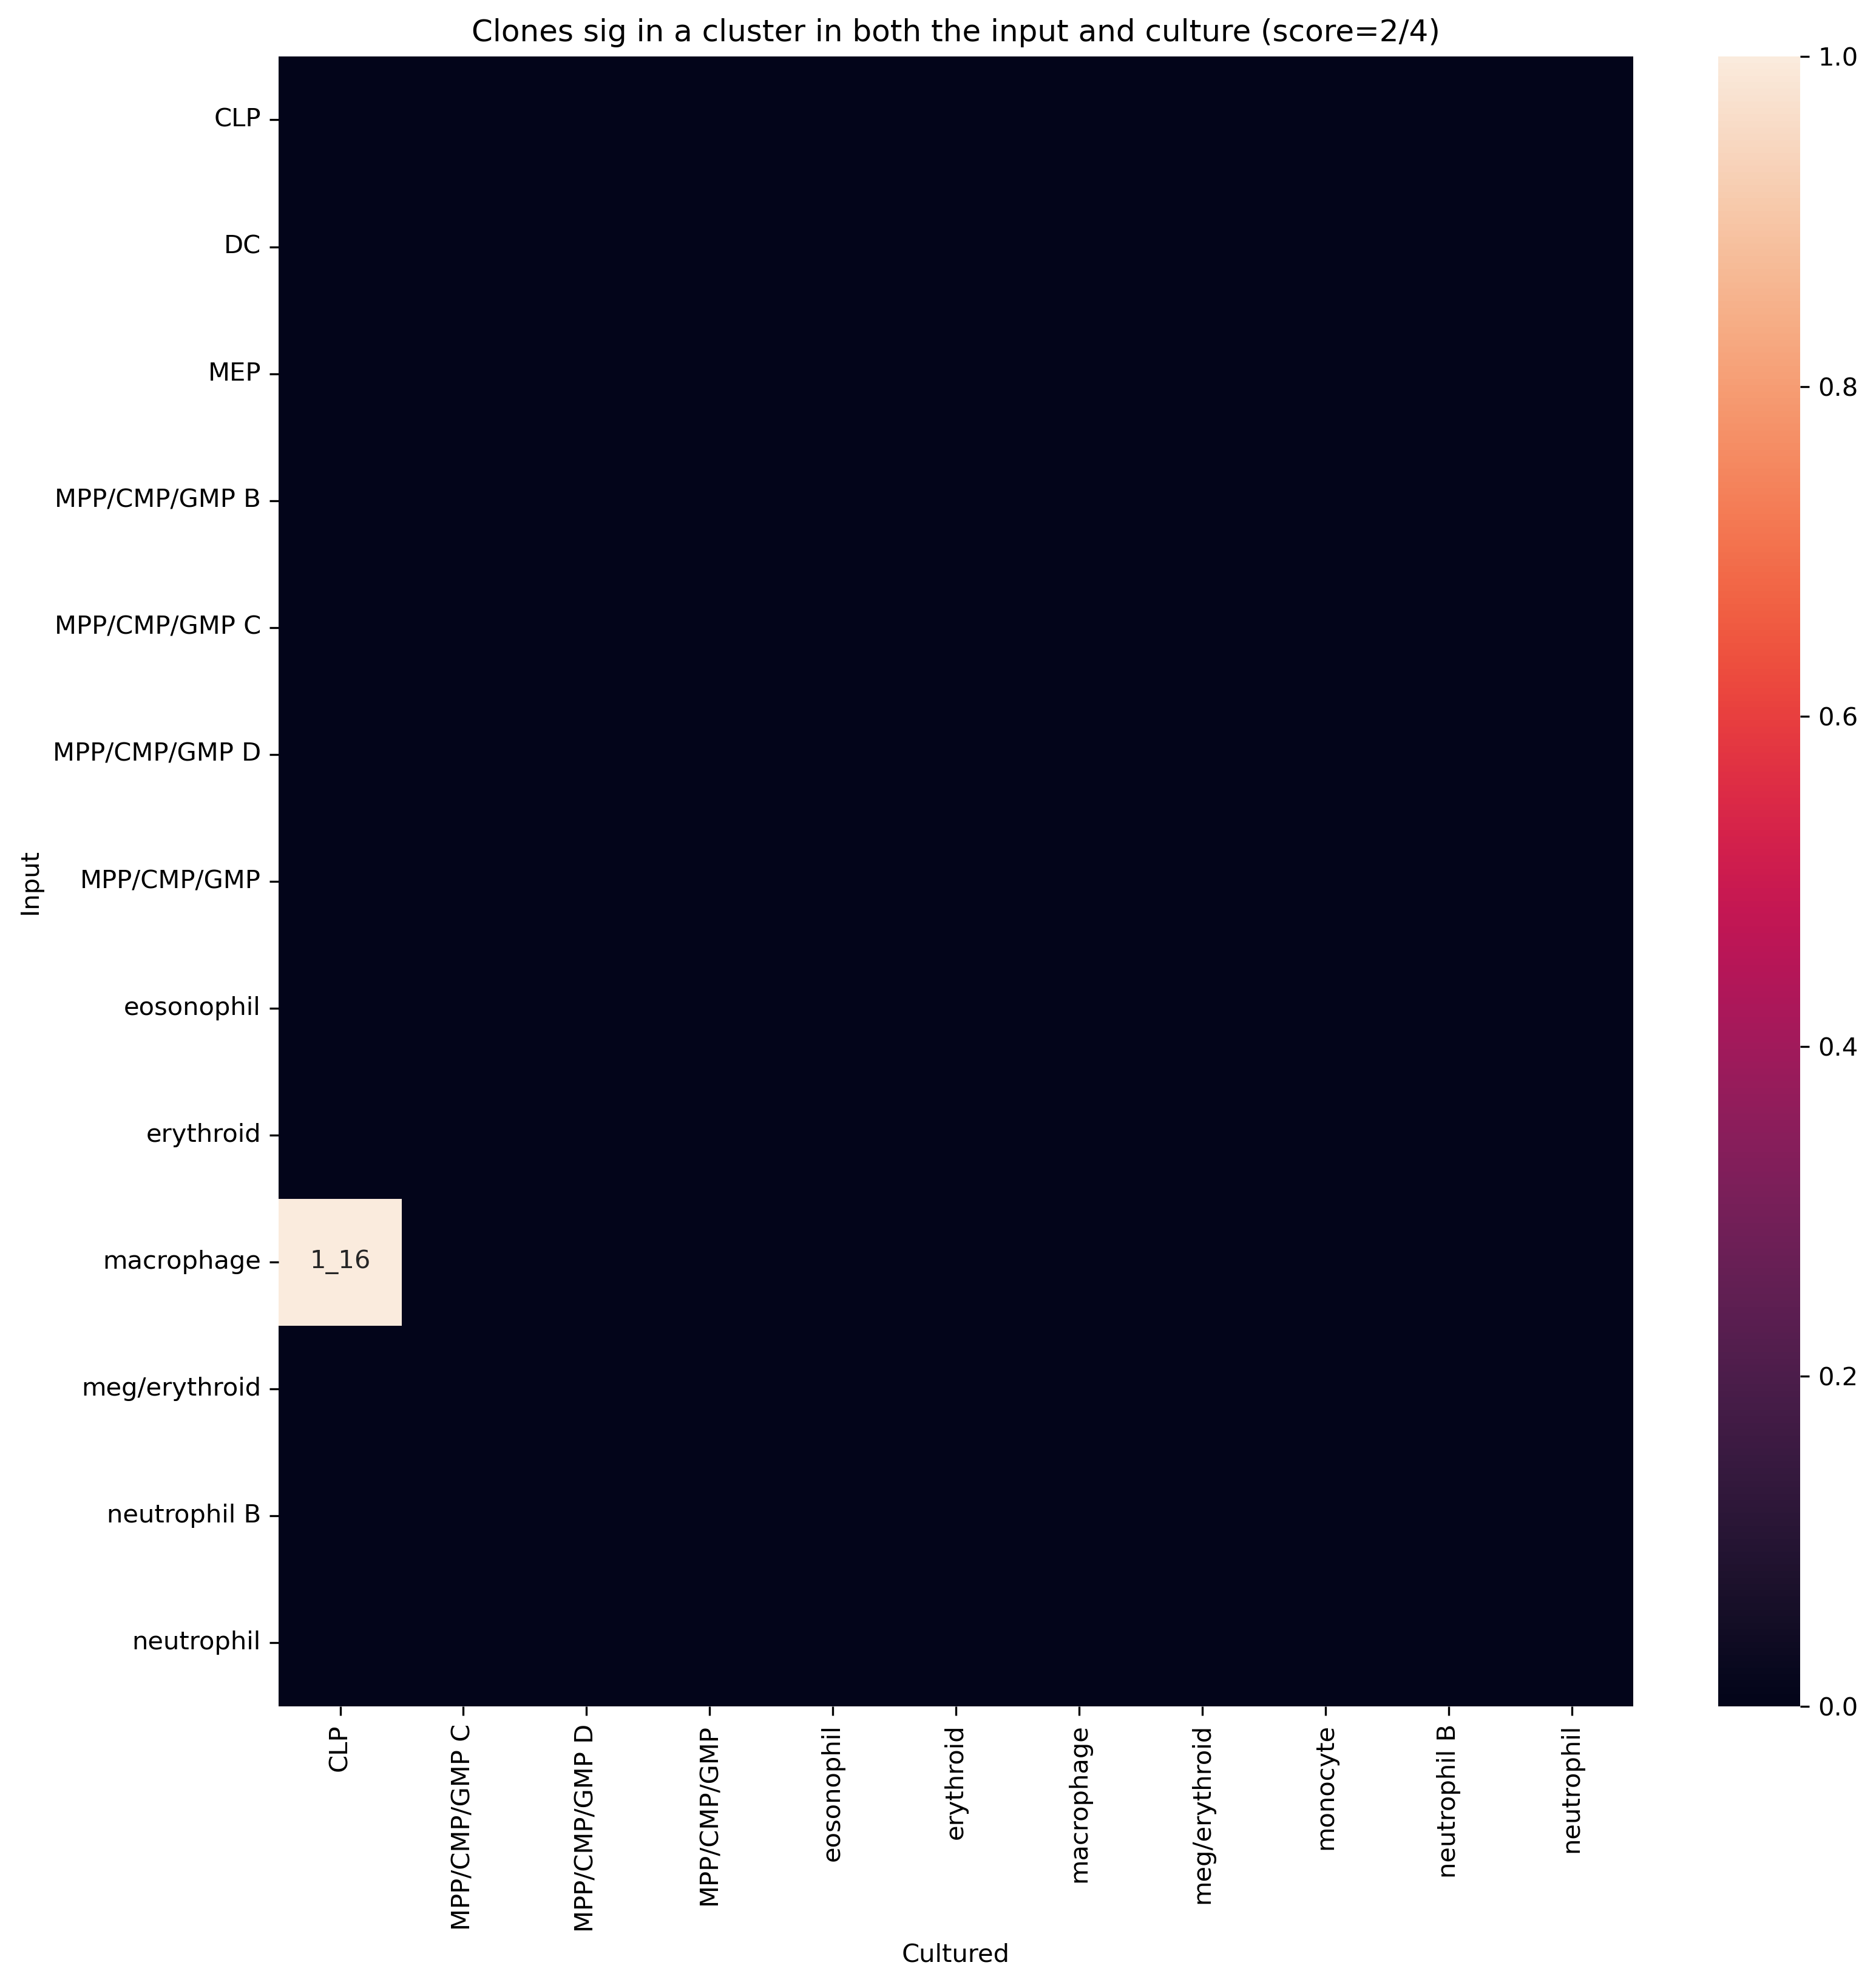

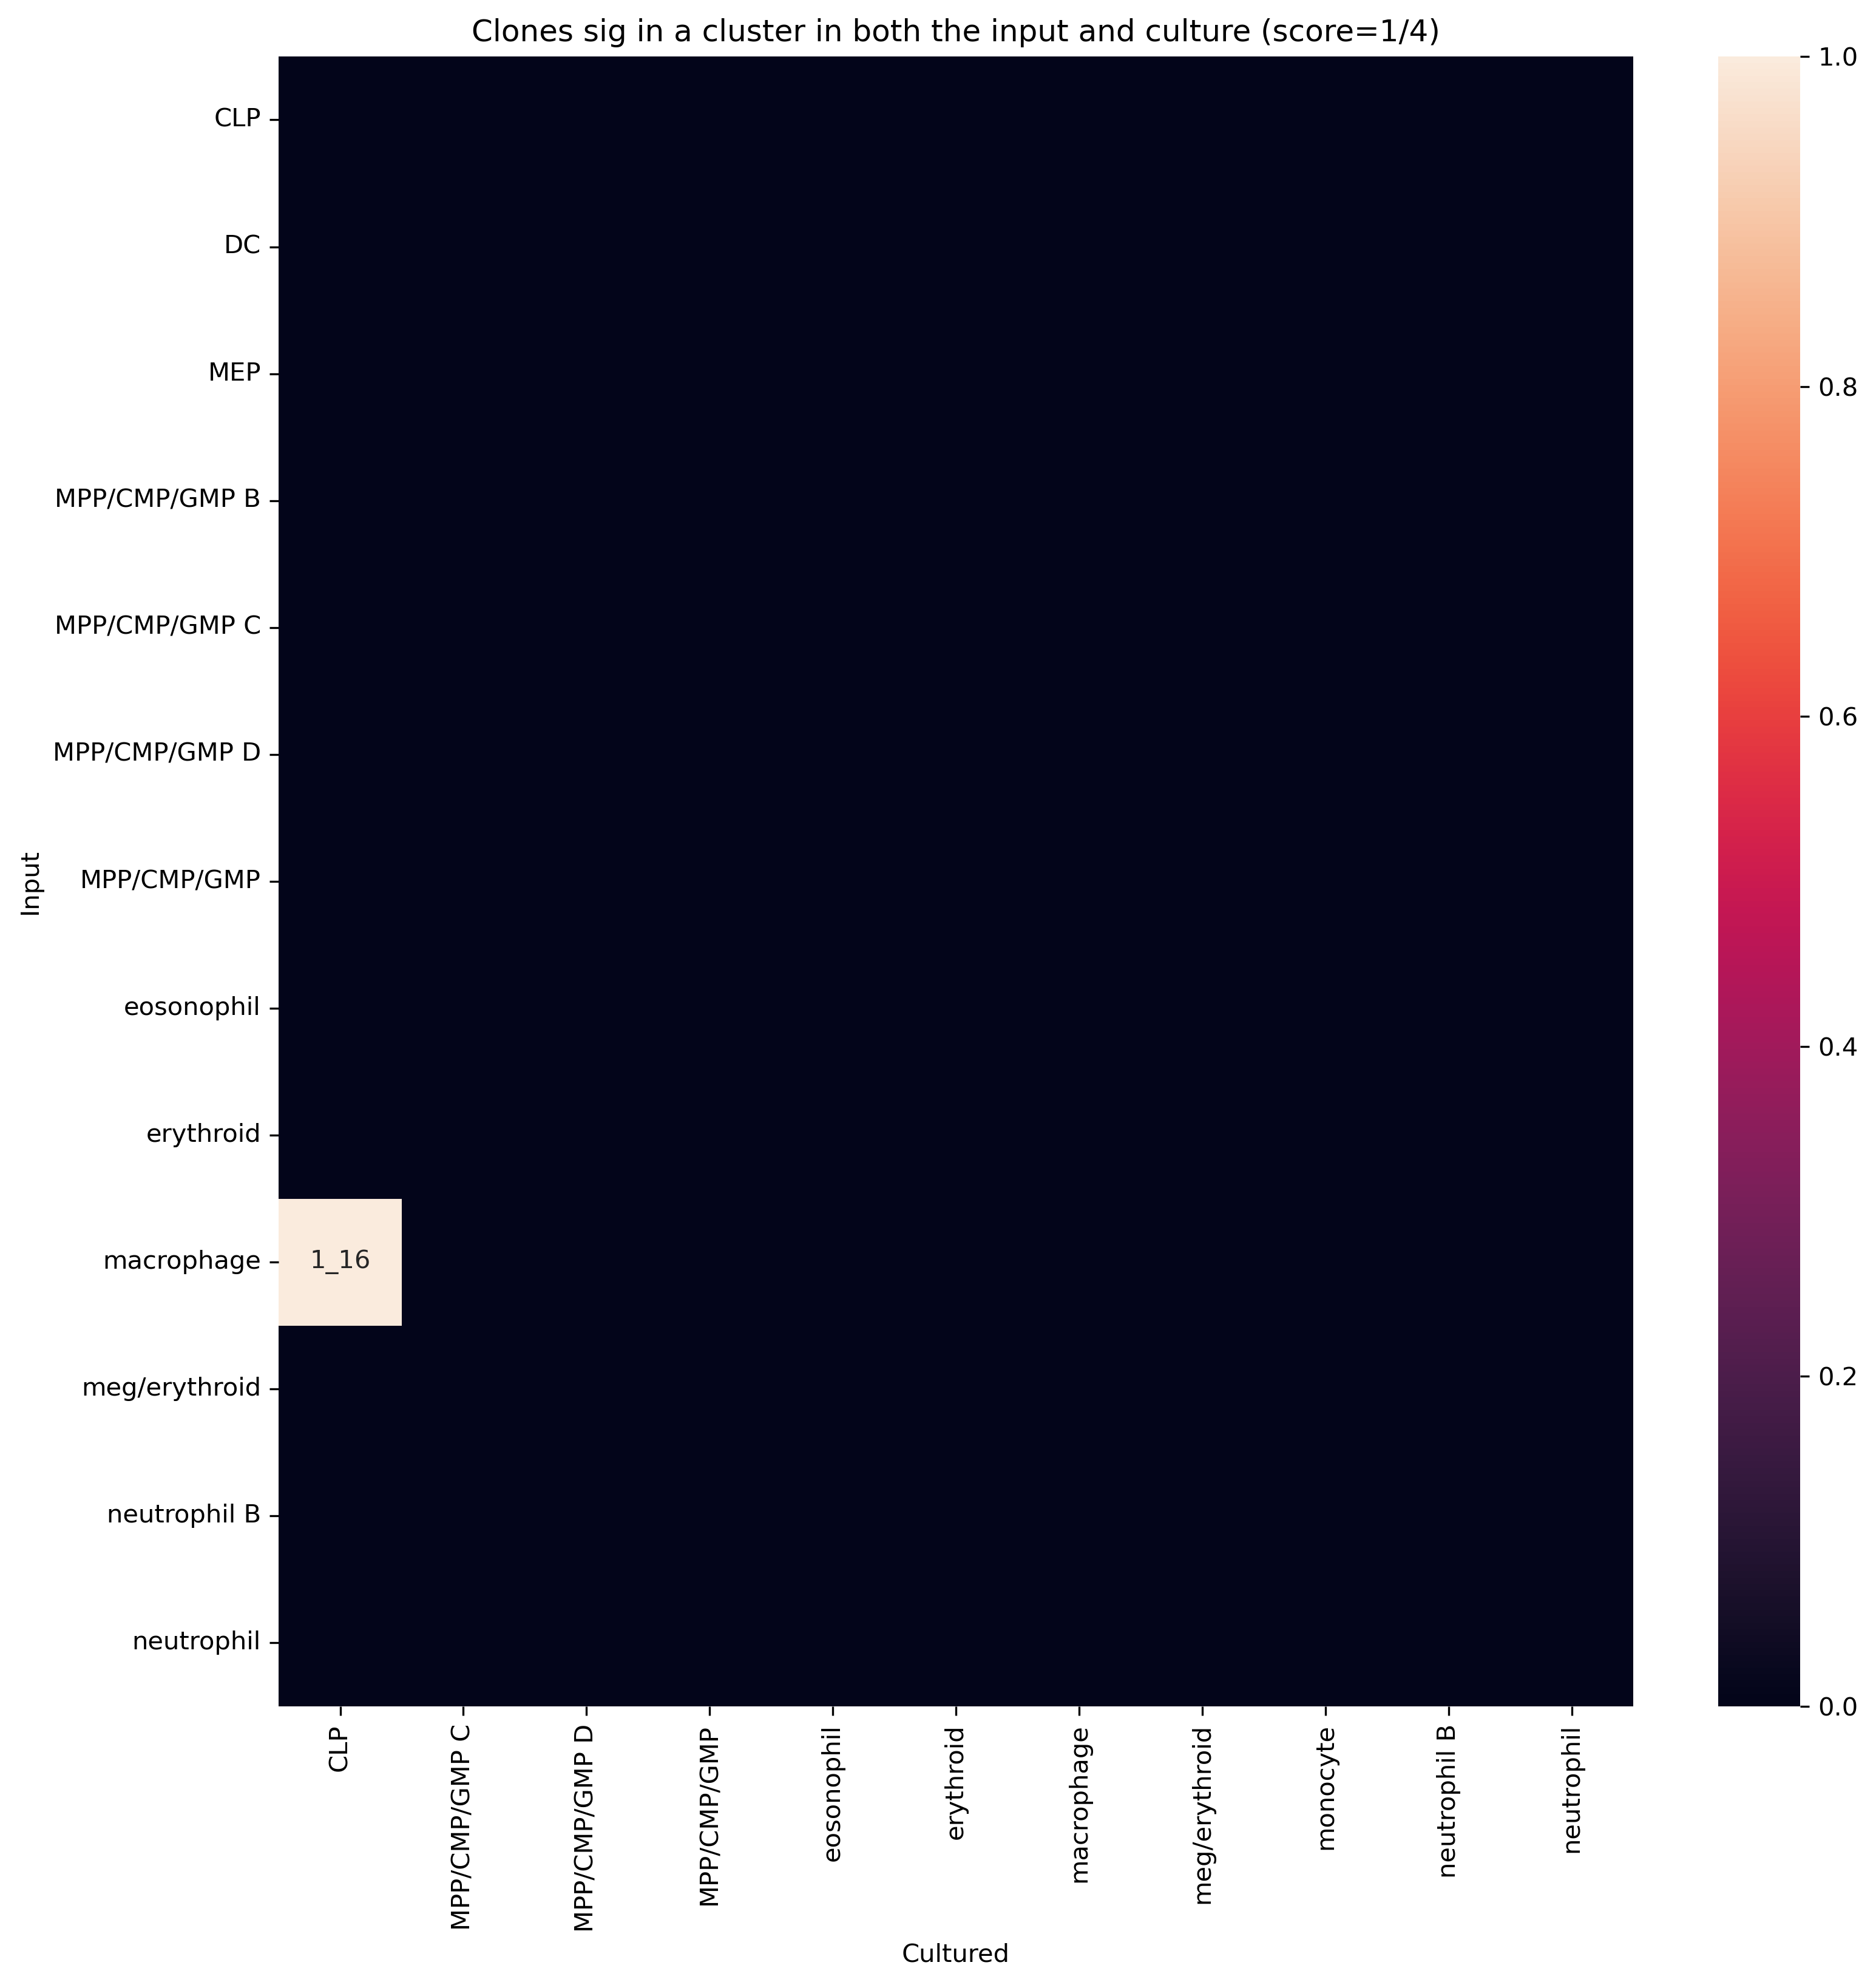

In [13]:
merged_df, merged_count_df = cs.merge_hypergeom(1/(1+a_sig), 1/(1+b_sig), 
                                               "Input", "Cultured", p_thresh=0.25,
                                                title="Clones sig in a cluster in both the input and culture (score=4/4)",
                                                f_save=join(outdir,f"sig_score4_culture_input_clone_lineages"))


merged_df, merged_count_df = cs.merge_hypergeom(1/(1+a_sig), 1/(1+b_sig), 
                                                "Input", "Cultured", p_thresh=0.33,
                                                title="Clones sig in a cluster in both the input and culture (score=3/4)",
                                                f_save=join(outdir,f"sig_score3_culture_input_clone_lineages"))


merged_df, merged_count_df = cs.merge_hypergeom(1/(1+a_sig), 1/(1+b_sig), 
                                             "Input", "Cultured", p_thresh=0.5,
                                             title="Clones sig in a cluster in both the input and culture (score=2/4)",
                                             f_save=join(outdir,f"sig_score2_culture_input_clone_lineages"))


merged_df, merged_count_df = cs.merge_hypergeom(1/(1+a_sig), 1/(1+b_sig), 
                                             "Input", "Cultured", p_thresh=1,
                                             title="Clones sig in a cluster in both the input and culture (score=1/4)",
                                             f_save=join(outdir,f"sig_score1_culture_input_clone_lineages"))


In [14]:
## Plot sig score for Input hypergeo and plot cultured on same clone-axis.

# g = sns.clustermap(p_df_out[clone_meta[clone_meta["condition"]=="input"].index])

# inds = g.dendrogram_row.dendrogram["leaves"]
# plt.savefig(join(outdir, "input_sigScore.pdf"))
# #cols = g.dendrogram_col.dendrogram["leaves"]
# #row_meta = row_meta.iloc[inds]

# sns.clustermap(p_df_out[clone_meta[clone_meta["condition"]=="cultured"].index].iloc[inds], 
#                row_cluster=False)

# plt.savefig(join(outdir, "cultured_sigScore.pdf"))

## Get the minimum of each clone shift. This will be used for rankigng later

In [15]:
min_df = df.groupby(["index", "method", "condition"]).min()["pval"].reset_index()
min_df

min_df_wide = min_df.pivot(index="index", values="pval", columns=["method", "condition"])
min_df_wide.columns = ['_'.join(col).strip() for col in min_df_wide.columns.values] # flatten to 1D columns
min_df_wide
ncells_df["ncells"] = ncells_df.sum(axis=1)
min_df_wide = pd.concat((min_df_wide,ncells_df), axis=1)


# *Get the clone order based on the ncells 


In [16]:

if is_mt:
    print("removing donor specific variants")
    print(min_df_wide.shape)
    clone_order_keep = []
    cells_meta = pd.read_csv(cells_meta_f, sep="\t", index_col=0)
    kept_clones = []
    kept_clones_cells = []
    
    for x in cells_meta.columns:
        if "cloneID_" in x:
            kept_clones_cells.append(x)
            kept_clones.append(x.replace("cloneID_", ""))
    
    min_df_wide = min_df_wide.loc[min_df_wide.index.isin(kept_clones)]
    print("after removal")
    print(min_df_wide.shape)
        

In [17]:
rank_df = pd.merge(min_df_wide.drop("ncells", axis=1).apply(lambda x: rankdata(x, method='max'), axis=0),
                   min_df_wide[["ncells"]].apply(lambda x: rankdata(x, method='min'), axis=0), 
                   left_index=True, right_index=True)
#rank_df = min_df_wide.apply(lambda x: rankdata(x, method='max'), axis=0)
# gmean_ser = rank_df.apply(gmean, axis=1)
# gmean_ser = gmean_ser.sort_values()
rank_df = rank_df.sort_values("ncells")[::-1]
rank_df
#for c in clone_order


,clone_all_cultured,clone_all_input,clone_min_cultured,clone_min_input,global_all_cultured,global_all_input,global_min_cultured,global_min_input,hypergeo_cultured,hypergeo_input,count_input,count_cultured,ncells
1_37,7,17,7,17,5,17,17,17,6,1,17,17,17
1_7,14,6,14,6,14,5,17,6,17,8,16,10,16
1_15,16,15,17,16,16,15,17,16,17,16,14,14,15
1_14,15,8,15,8,15,8,17,16,17,9,9,16,14
1_16,1,3,1,3,1,7,1,7,1,8,12,13,13
1_19,13,14,13,14,13,12,17,16,17,13,15,6,12
1_18,17,11,16,11,17,10,17,16,17,11,5,15,11
1_21,12,16,12,16,12,16,17,16,17,17,13,9,10
1_22,10,9,11,10,9,9,17,16,10,10,6,11,9
1_23,11,1,11,1,11,1,17,1,17,2,1,12,8


In [18]:

## Get the clone order based on the mean of the rankings
clone_order = rank_df.index
min_df_wide = min_df_wide.loc[clone_order]
rank_df = rank_df.loc[clone_order]
rank_df

,clone_all_cultured,clone_all_input,clone_min_cultured,clone_min_input,global_all_cultured,global_all_input,global_min_cultured,global_min_input,hypergeo_cultured,hypergeo_input,count_input,count_cultured,ncells
1_37,7,17,7,17,5,17,17,17,6,1,17,17,17
1_7,14,6,14,6,14,5,17,6,17,8,16,10,16
1_15,16,15,17,16,16,15,17,16,17,16,14,14,15
1_14,15,8,15,8,15,8,17,16,17,9,9,16,14
1_16,1,3,1,3,1,7,1,7,1,8,12,13,13
1_19,13,14,13,14,13,12,17,16,17,13,15,6,12
1_18,17,11,16,11,17,10,17,16,17,11,5,15,11
1_21,12,16,12,16,12,16,17,16,17,17,13,9,10
1_22,10,9,11,10,9,9,17,16,10,10,6,11,9
1_23,11,1,11,1,11,1,17,1,17,2,1,12,8


In [19]:
min_df_wide.loc[clone_order]

,clone_all_cultured,clone_all_input,clone_min_cultured,clone_min_input,global_all_cultured,global_all_input,global_min_cultured,global_min_input,hypergeo_cultured,hypergeo_input,count_input,count_cultured,ncells
1_37,0.032727,NaN,0.328,NaN,0.021005,NaN,1.0,NaN,0.287236,0.000000,NaN,NaN,NaN
1_7,0.088727,0.011692,0.704,0.144,0.139936,0.013808,1.0,0.976,0.372021,0.094260,218.0,102.0,320.0
1_15,0.116364,0.160615,0.832,0.968,0.183829,0.222615,1.0,1.000,0.372021,0.388121,67.0,129.0,196.0
1_14,0.093091,0.024000,0.736,0.264,0.155422,0.022923,1.0,1.000,0.372021,0.099017,43.0,152.0,195.0
1_16,0.000000,0.004923,0.000,0.064,0.000000,0.016577,0.0,0.992,0.099990,0.094260,54.0,128.0,182.0
1_19,0.062545,0.082462,0.528,0.736,0.097369,0.095769,1.0,1.000,0.372021,0.265103,114.0,61.0,175.0
1_18,0.120000,0.036923,0.776,0.432,0.201711,0.039615,1.0,1.000,0.372021,0.169218,35.0,138.0,173.0
1_21,0.050909,0.184000,0.480,0.968,0.089497,0.322346,1.0,1.000,0.372021,0.393321,55.0,100.0,155.0
1_22,0.045818,0.033846,0.424,0.384,0.064941,0.032769,1.0,1.000,0.368756,0.146461,37.0,104.0,141.0
1_23,0.047273,0.000615,0.424,0.008,0.073840,0.001385,1.0,0.272,0.372021,0.028983,11.0,124.0,135.0


In [20]:
min_clone_meta = pd.DataFrame(index=min_df_wide.columns, columns = ["condition"])
min_clone_meta["condition"] = ["input" if "input" in x else "cultured" for x in min_clone_meta.index]
min_clone_meta

,condition
clone_all_cultured,cultured
clone_all_input,input
clone_min_cultured,cultured
clone_min_input,input
global_all_cultured,cultured
global_all_input,input
global_min_cultured,cultured
global_min_input,input
hypergeo_cultured,cultured
hypergeo_input,input


## Plot rankings ordered by clone, annd save output

## Save:
a) cloneID_rank.png  
b) cloneID_order.txt - line-delimited text file with cloneID on each line  
c) cloneID_rank.csv  - csv file of the ranking for each category  
d) all_pvals: all p-values for for each clone-method-cluster-condition

In [21]:
clone_order

Index(['1_37', '1_7', '1_15', '1_14', '1_16', '1_19', '1_18', '1_21', '1_22',
       '1_23', '1_26', '1_28', '1_27', '1_30', '1_29', '1_31', '1_35'],
      dtype='object')

In [22]:
with open(join(outdir, "cloneID_rank_ncells.txt"), 'w') as f:
    f.write('\n'.join(clone_order))

In [23]:
rank_df.to_csv(join(outdir, "cloneID_rank_ncells_df.csv"))

## Plot the rankings

In [24]:
rank_df

,clone_all_cultured,clone_all_input,clone_min_cultured,clone_min_input,global_all_cultured,global_all_input,global_min_cultured,global_min_input,hypergeo_cultured,hypergeo_input,count_input,count_cultured,ncells
1_37,7,17,7,17,5,17,17,17,6,1,17,17,17
1_7,14,6,14,6,14,5,17,6,17,8,16,10,16
1_15,16,15,17,16,16,15,17,16,17,16,14,14,15
1_14,15,8,15,8,15,8,17,16,17,9,9,16,14
1_16,1,3,1,3,1,7,1,7,1,8,12,13,13
1_19,13,14,13,14,13,12,17,16,17,13,15,6,12
1_18,17,11,16,11,17,10,17,16,17,11,5,15,11
1_21,12,16,12,16,12,16,17,16,17,17,13,9,10
1_22,10,9,11,10,9,9,17,16,10,10,6,11,9
1_23,11,1,11,1,11,1,17,1,17,2,1,12,8


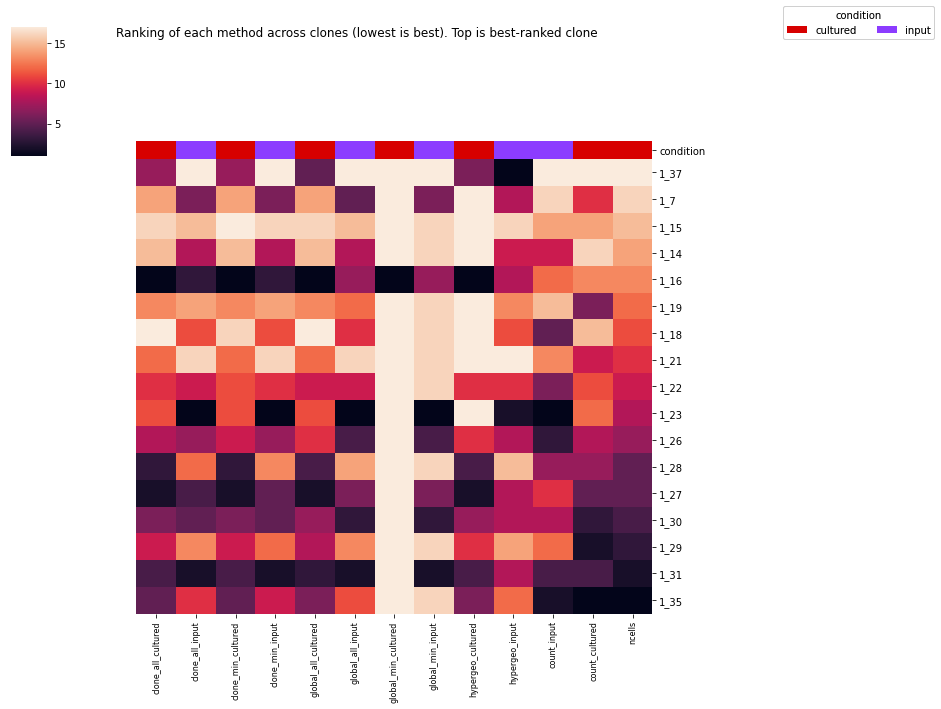

In [25]:
g = ch.plot_cluster(rank_df, to_row_clust=False, to_col_clust=False, col_meta=min_clone_meta[["condition"]])
g.fig.suptitle("Ranking of each method across clones (lowest is best). Top is best-ranked clone")
plt.savefig(join(outdir, "cloneID_rank_sizes.png"))

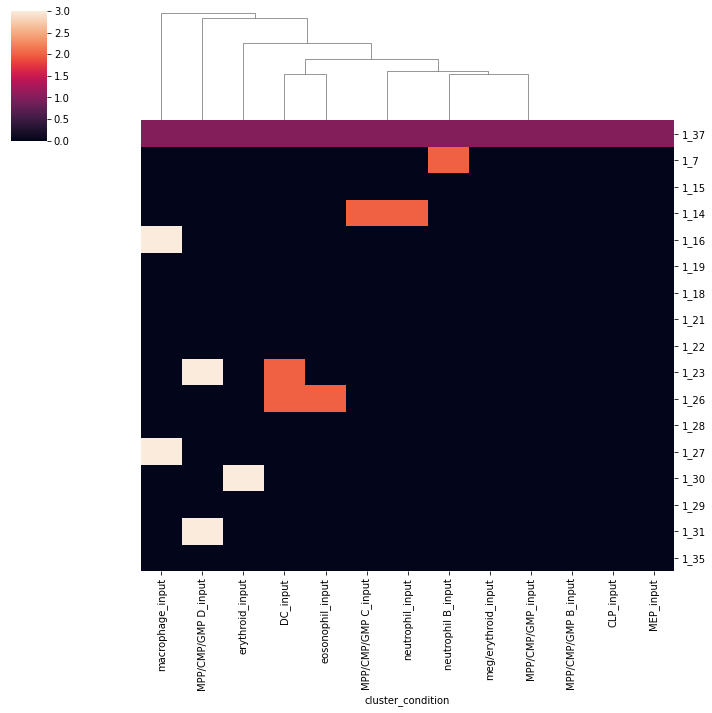

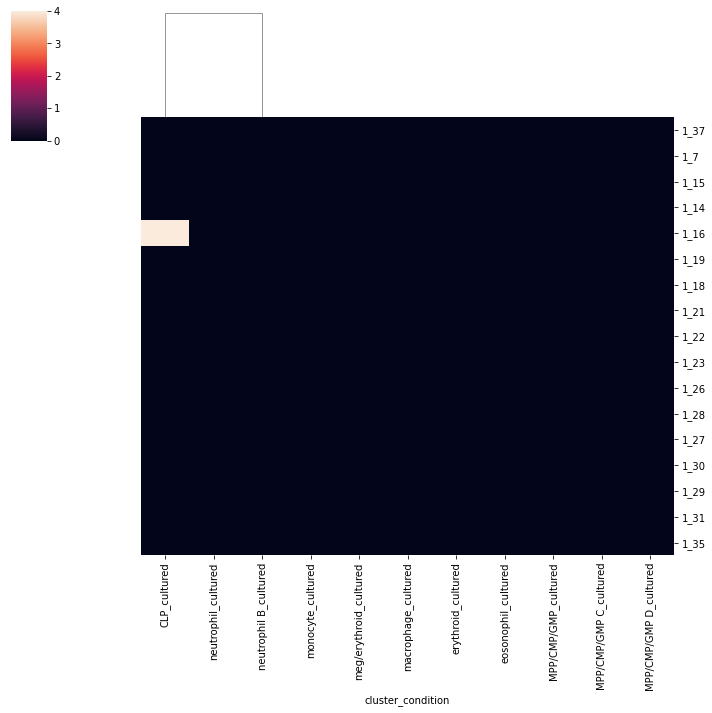

In [26]:
g = sns.clustermap(p_df_out[clone_meta[clone_meta["condition"]=="input"].index].loc[clone_order], row_cluster=False)
plt.savefig(join(outdir, "input_sigScore_cloneOrder.pdf"))
#inds = g.dendrogram_row.dendrogram["leaves"]

#cols = g.dendrogram_col.dendrogram["leaves"]
#row_meta = row_meta.iloc[inds]

sns.clustermap(p_df_out[clone_meta[clone_meta["condition"]=="cultured"].index].loc[clone_order], 
               row_cluster=False)

plt.savefig(join(outdir, "cultured_sigScore_cloneOrder.pdf"))

## Convert p-vals into * or shapes (a. hypergeo sig. b. hyper+global all c. hyper+global all + clone min d. hyper+global all + clone min + global min